In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
device

device(type='cuda')

In [3]:
# Define a basic transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
train_dataset = datasets.CIFAR10(root='./data',\
              train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(train_dataset, \
                                batch_size=32, shuffle=True)

100%|██████████| 170498071/170498071 [00:02<00:00, 82442669.50it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


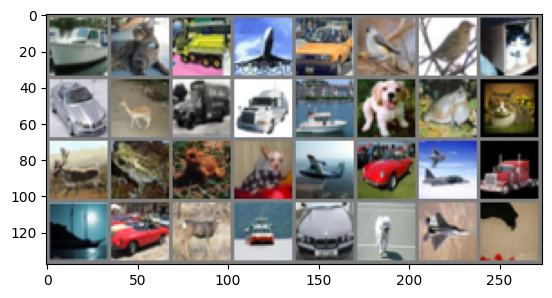

In [5]:
# Function to display images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize the image (assuming mean and std are 0.5)
    npimg = img.numpy()  # convert to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # rearrange dimensions for displaying
    plt.show()

# Get a batch of training data
dataiter = iter(dataloader)
images, labels = next(dataiter)  # Correct usage of next()

# Show images
imshow(torchvision.utils.make_grid(images))

In [6]:
# Hyperparameters
latent_dim = 100
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
num_epochs = 10

In [7]:
# Define the generator
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (128, 8, 8)),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128, momentum=0.78),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64, momentum=0.78),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img

In [8]:
generator = Generator(latent_dim=100)
generator

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(128, 8, 8))
    (3): Upsample(scale_factor=2.0, mode='nearest')
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.78, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Upsample(scale_factor=2.0, mode='nearest')
    (8): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.78, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): Tanh()
  )
)

In [9]:
# Define the discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.25),
        nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        nn.ZeroPad2d((0, 1, 0, 1)),
        nn.BatchNorm2d(64, momentum=0.82),
        nn.LeakyReLU(0.25),
        nn.Dropout(0.25),
        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(128, momentum=0.82),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.25),
        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256, momentum=0.8),
        nn.LeakyReLU(0.25),
        nn.Dropout(0.25),
        nn.Flatten(),
        nn.Linear(256 * 5 * 5, 1),
        nn.Sigmoid()
    )

    def forward(self, img):
        validity = self.model(img)
        return validity

In [10]:
discriminator=Discriminator()
discriminator

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.25, inplace=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ZeroPad2d((0, 1, 0, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.82, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.25)
    (7): Dropout(p=0.25, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.82, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Dropout(p=0.25, inplace=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.25)
    (15): Dropout(p=0.25, inplace=False)
    (16): Flatten(start_dim=1, e

In [11]:
# Initialize generator and discriminator
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
# Loss function
adversarial_loss = nn.BCELoss()
# Optimizers
optimizer_G = optim.Adam(generator.parameters()\
                         , lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters()\
                         , lr=lr, betas=(beta1, beta2))

Epoch [1/10]                        Batch 100/1563 Discriminator Loss: 0.6359 Generator Loss: 1.2116
Epoch [1/10]                        Batch 200/1563 Discriminator Loss: 0.6014 Generator Loss: 1.0661
Epoch [1/10]                        Batch 300/1563 Discriminator Loss: 0.6525 Generator Loss: 1.2860
Epoch [1/10]                        Batch 400/1563 Discriminator Loss: 0.5829 Generator Loss: 1.1128
Epoch [1/10]                        Batch 500/1563 Discriminator Loss: 0.6911 Generator Loss: 1.1836
Epoch [1/10]                        Batch 600/1563 Discriminator Loss: 0.5206 Generator Loss: 1.2135
Epoch [1/10]                        Batch 700/1563 Discriminator Loss: 0.6900 Generator Loss: 1.0020
Epoch [1/10]                        Batch 800/1563 Discriminator Loss: 0.6423 Generator Loss: 1.4261
Epoch [1/10]                        Batch 900/1563 Discriminator Loss: 0.6281 Generator Loss: 1.0533
Epoch [1/10]                        Batch 1000/1563 Discriminator Loss: 0.5526 Generator Lo

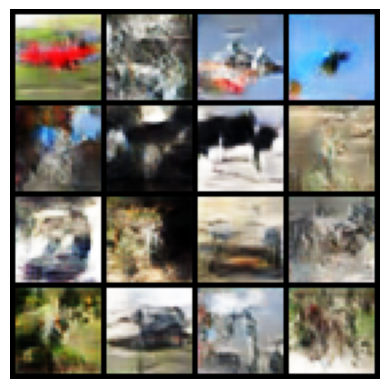

In [12]:
# Training loop
for epoch in range(num_epochs):
    for i, batch in enumerate(dataloader):
       # Convert list to tensor
        real_images = batch[0].to(device) 
        # Adversarial ground truths
        valid = torch.ones(real_images.size(0), 1, device=device)
        fake = torch.zeros(real_images.size(0), 1, device=device)
        # Configure input
        real_images = real_images.to(device)

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        # Sample noise as generator input
        z = torch.randn(real_images.size(0), latent_dim, device=device)
        # Generate a batch of images
        fake_images = generator(z)

        # Measure discriminator's ability 
        # to classify real and fake images
        real_loss = adversarial_loss(discriminator\
                                     (real_images), valid)
        fake_loss = adversarial_loss(discriminator\
                                     (fake_images.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        # Backward pass and optimize
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()
        # Generate a batch of images
        gen_images = generator(z)
        # Adversarial loss
        g_loss = adversarial_loss(discriminator(gen_images), valid)
        # Backward pass and optimize
        g_loss.backward()
        optimizer_G.step()
        # ---------------------
        #  Progress Monitoring
        # ---------------------
        if (i + 1) % 100 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}]\
                        Batch {i+1}/{len(dataloader)} "
                f"Discriminator Loss: {d_loss.item():.4f} "
                f"Generator Loss: {g_loss.item():.4f}"
            )
    # Save generated images for every epoch
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            z = torch.randn(16, latent_dim, device=device)
            generated = generator(z).detach().cpu()
            grid = torchvision.utils.make_grid(generated,\
                                        nrow=4, normalize=True)
            plt.imshow(np.transpose(grid, (1, 2, 0)))
            plt.axis("off")
            plt.show()

In [15]:
# Define a classifier model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.model(x)

# Initialize classifier, criterion, and optimizer
classifier = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

# Training function
def train_model(model, dataloader, optimizer, criterion, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluation function
def evaluate_model(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Function to generate synthetic data in smaller batches
def generate_synthetic_data_in_batches(generator, num_samples, batch_size=128):
    synthetic_images = []
    synthetic_labels = []
    for _ in range(num_samples // batch_size):
        z = torch.randn(batch_size, latent_dim, device=device)
        with torch.no_grad():
            batch_images = generator(z).detach().cpu()
        batch_labels = torch.randint(0, 10, (batch_size,))  # Random labels for synthetic images
        synthetic_images.append(batch_images)
        synthetic_labels.append(batch_labels)
    # Concatenate all batches
    synthetic_images = torch.cat(synthetic_images)
    synthetic_labels = torch.cat(synthetic_labels)
    return synthetic_images, synthetic_labels

# Train on Real Data
print("Training on Real Data...")
train_model(classifier, dataloader, optimizer, criterion, num_epochs)

# Evaluate on Real Data
real_accuracy = evaluate_model(classifier, dataloader)
print(f"Classifier Accuracy on Real CIFAR-10 Data: {real_accuracy:.2f}%")

# Generate synthetic dataset in smaller batches
print("Generating Synthetic Data...")
num_synthetic_samples = len(train_dataset)
synthetic_images, synthetic_labels = generate_synthetic_data_in_batches(generator, num_synthetic_samples)

# Wrap synthetic data in a DataLoader
synthetic_dataset = torch.utils.data.TensorDataset(synthetic_images, synthetic_labels)
synthetic_dataloader = torch.utils.data.DataLoader(synthetic_dataset, batch_size=32, shuffle=True)

# Train on Synthetic Data Only
print("Training on Synthetic Data...")
train_model(classifier, synthetic_dataloader, optimizer, criterion, num_epochs)

# Evaluate on Synthetic Data
synthetic_accuracy = evaluate_model(classifier, synthetic_dataloader)
print(f"Classifier Accuracy on Synthetic Data: {synthetic_accuracy:.2f}%")

Training on Real Data...
Epoch [1/10], Loss: 1.2761
Epoch [2/10], Loss: 0.7372
Epoch [3/10], Loss: 0.3334
Epoch [4/10], Loss: 0.3661
Epoch [5/10], Loss: 0.2978
Epoch [6/10], Loss: 1.2167
Epoch [7/10], Loss: 0.1972
Epoch [8/10], Loss: 0.1922
Epoch [9/10], Loss: 0.0595
Epoch [10/10], Loss: 0.1332
Classifier Accuracy on Real CIFAR-10 Data: 96.58%
Generating Synthetic Data...
Training on Synthetic Data...
Epoch [1/10], Loss: 2.3004
Epoch [2/10], Loss: 2.3053
Epoch [3/10], Loss: 2.3026
Epoch [4/10], Loss: 2.3056
Epoch [5/10], Loss: 2.3019
Epoch [6/10], Loss: 2.3003
Epoch [7/10], Loss: 2.3038
Epoch [8/10], Loss: 2.3051
Epoch [9/10], Loss: 2.3034
Epoch [10/10], Loss: 2.3019
Classifier Accuracy on Synthetic Data: 10.05%
